In [ ]:
## Install Packages

!pip install matplotlib
import matplotlib
matplotlib.use('Agg')
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib ipympl

# Install mmdetection
!pip install -U openmim
!mim install mmengine
!mim install "mmcv>=2.0.0"
!mim install mmdet

In [ ]:
# Download a checkpoint, config and a sample video.
!wget http://codingai-s3.s3.amazonaws.com/public/crowdhuman_demo_config.py
!wget http://codingai-s3.s3.amazonaws.com/public/small_shinjuku_1.mp4
!wget http://codingai-s3.s3.amazonaws.com/public/crowdhuman_epoch_24.pth

In [ ]:
#@title Hidden Functions

import imageio, cv2
import numpy as np
from google.colab.patches import cv2_imshow

class VideoWriter:
    def __init__(self,name,fps=10):
        self.name=f'{name}.mp4'
        self.video = imageio.get_writer(self.name, mode='I', fps=fps, codec='libx264', bitrate='1M')
    def write(self,img):
        """
        BGR input
        """
        self.video.append_data(img[:,:,::-1])
    def release(self):
        print(f"Wrote to {self.name}")
        self.video.close()
def video_rewrite(vid):
    """
    rewrites a video in format for google colab
    """
    cam = cv2.VideoCapture(vid)
    vw = VideoWriter('tmp',fps=10)
    while True:
        ret,img = cam.read()
        if not ret:
            break
        vw.write(img)
    vw.release()


def get_still_images_from_video(vid_name,inds = {0}):
    """
    This function is to retrieve a few still images from a video
    for demonstration purposes
    """
    cam = cv2.VideoCapture(vid_name)
    imgs = []
    i = 0
    while True:
      ret,img = cam.read()
      if not ret:
        break
      if i in inds:
        imgs.append(img)
      i+=1
    return imgs


def img_grid(images):
    return np.concatenate(images,axis=0)
### ALL OTHER FUNCTIONS
from IPython.display import HTML
from base64 import b64encode
def visualize_images(model, images):
  vis_images = []
  for image in images:
    result = inference_detector(model, image, test_pipeline=test_pipeline)

    visualizer.add_datasample(
            'result',
            image,
            data_sample=result,
            draw_gt=False)
    vis_image = visualizer.get_image()
    vis_images.append(vis_image)
  return vis_images


DEFINITION = {
    0:'person'
}
class Detection:
  def __init__(self,box,label,score):
    self.box=box
    self.label=DEFINITION[label]
    self.score=score
  def __str__(self):
    return(f"{self.label} | {self.score} | {self.box}")

def get_detections_from_result(result):
    instances = result.pred_instances.numpy().cpu()
    return [Detection(box,label,score) for box,label,score in zip(instances['bboxes'],instances['labels'],instances['scores'])]
def visualize_boxes(image,dets,color = [0,255,0]):
    """
    Visualizes detections
    """
    new_image = image.copy()
    for det in dets:
        box = [int(round(j)) for j in det.box]
        cv2.rectangle(new_image,box[:2],box[2:],color,3)
    return new_image
def iou(x1_1, y1_1, x2_1, y2_1,
        x1_2, y1_2, x2_2, y2_2):
    intersection_width = max(min(x2_1, x2_2) - max(x1_1, x1_2),0)
    intersection_height = max(min(y2_1, y2_2) - max(y1_1, y1_2),0)
    intersection_area = intersection_width * intersection_height
    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = box1_area + box2_area - intersection_area
    return intersection_area / union_area
COLORS = [
    (255, 0, 0),     # Red
    (255, 127, 0),   # Orange
    (255, 255, 0),   # Yellow
    (191, 255, 0),   # Chartreuse green
    (0, 255, 0),     # Green
    (0, 255, 127),   # Spring green
    (0, 255, 255),   # Cyan / Aqua
    (0, 191, 255),   # Sky blue
    (0, 0, 255),     # Blue
    (127, 0, 255),   # Purple / Violet
    (255, 0, 255),   # Magenta / Fuchsia
    (255, 0, 191),   # Hot pink
    (255, 0, 127),   # Pink
    (255, 63, 0),    # Dark orange
    (255, 127, 63),  # Light orange
    (255, 191, 127), # Peach
    (255, 255, 127), # Pastel yellow
    (191, 255, 127), # Light green
    (127, 255, 127), # Mint green
    (127, 255, 191), # Seafoam green
    (127, 255, 255), # Light blue
    (127, 191, 255), # Periwinkle
    (127, 127, 255), # Lavender
    (191, 127, 255), # Lilac
    (255, 127, 255), # Pale pink
    (255, 127, 191), # Salmon pink
    (255, 127, 127), # Coral
    (255, 191, 191), # Pastel pink
    (255, 191, 127), # Apricot
    (255, 191, 191)  # Blush pink
]
def iou(x1_1, y1_1, x2_1, y2_1,
        x1_2, y1_2, x2_2, y2_2):
    intersection_width = max(min(x2_1, x2_2) - max(x1_1, x1_2),0)
    intersection_height = max(min(y2_1, y2_2) - max(y1_1, y1_2),0)
    intersection_area = intersection_width * intersection_height
    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = box1_area + box2_area - intersection_area
    return intersection_area / union_area
class TrackedObject:
    def __init__(self,idx,box,reset_threshold=60):
        self.idx = idx
        self.box = box
        self.unused_count = 0
        self.start_centroid = [(box[0]+box[2])/2,(box[1]+box[3])/2]#x,y
        self.current_centroid = [(box[0]+box[2])/2,(box[1]+box[3])/2]
        self.has_crossed = False
        self.direction = ''
        self.reset_threshold = reset_threshold
        self.cross_count = 0

    def update(self,box):
        self.box = box
        self.unused_count = 0
        self.current_centroid = [(box[0]+box[2])/2,(box[1]+box[3])/2]#x,y
        if self.has_crossed:
            self.cross_count+=1
            if self.cross_count>=self.reset_threshold:
                self.has_crossed=False
                self.start_centroid = [(box[0]+box[2])/2,(box[1]+box[3])/2]#x,y
    def unused(self):
        self.unused_count+=1
    def get_has_crossed(self):
        return self.has_crossed
    def mark_crossed(self):
        self.has_crossed = True
        self.cross_count = 0
        self.up_or_down()
    def up_or_down(self):
        y0 = self.start_centroid[1]
        y1 = self.current_centroid[1]
        self.direction='up'
        if y1>y0:
            self.direction = 'down'
    def get_unused_count(self):
        return self.unused_count
    def get_direction(self):
        return self.direction
    def get_box(self):
        return self.box
    def get_idx(self):
        return self.idx
    def get_has_crossed(self):
        return self.has_crossed
    def get_start_centroid(self):
        return self.start_centroid
    def get_current_centroid(self):
        return self.current_centroid
    def get_cross_count(self):
        return self.cross_count
class Tracker:
    def __init__(self,unused_threshold=10,printout=False,object_reset_threshold=100):
        self.objects = []
        self.count = 0
        self.unused_threshold = unused_threshold
        self.printout = printout
        self.object_reset_threshold=object_reset_threshold

    def track(self,new_boxes):
        old_boxes = [obj.get_box() for obj in self.objects]
        #old_unmatched = []
        remove_oboxes = [False for _ in old_boxes]
        used_boxes = [False for _ in new_boxes]
        matched = []
        for o,obox in enumerate(old_boxes):
            #greedy
            ious = [self._iou(obox,nbox,ubox) for nbox,ubox in zip(new_boxes,used_boxes)]
            #print(ious)
            idx = self._max_idx(ious)

            if idx is None:
                #old_unmatched.append(self.objects[o])
                self.objects[o].unused()
                #print(ious,idx,self.objects[o].unused_count)
                 # remove lingering boxes
                if self.objects[o].get_unused_count() >= self.unused_threshold:
                    remove_oboxes[o]=True
            else:
                used_boxes[idx]=True
                self.objects[o].update(new_boxes[idx])

        # remove lingering boxes
        self.objects = [obj for obj,rbox in zip(self.objects,remove_oboxes) if not rbox]

        temp = len(self.objects)
        # unmatched new boxes
        for nbox,ubox in zip(new_boxes,used_boxes):
            if not ubox:
                self.objects.append(TrackedObject(self.count,nbox,reset_threshold=self.object_reset_threshold))
                self.count+=1
        if self.printout:

            info = {
                "OldBoxes": len(remove_oboxes),
                "RemovedBoxes": sum(remove_oboxes),
                "Matches": sum(used_boxes),
                "NewBoxes": len(new_boxes),
                "NewBoxesAppended":len(self.objects)-temp,
                "Total": len(self.objects)
            }
            for k,v in info.items():
                print(f"{k}:{v}")
            print('='*40)

    def _iou(self,obox,nbox,ubox):
        if ubox:
            return 0
        return iou(*obox,*nbox)

    def _max_idx(self,my_list):
        # only positive numbers for my_list
        best = 1e-5
        best_idx = None
        for idx,item in enumerate(my_list):
            if item > best:
                best=item
                best_idx = idx
        return best_idx
    def get_objects(self):
        return self.objects

def visualize_tracker(im,tracker):
    """
    Visualizes what the tracker is doing
    This code is tied to the variables seen in tracker.py
    """
    for obj in tracker.get_objects():
        # If a tracked object is not found on current frame, don't display its box
        if obj.get_unused_count()>1:
            continue

        # If an object has crossed the line and , color is BLACK
        if obj.get_has_crossed():
                color = [0,0,0]
        # Assign each tracked object a color based on its idx (index number)
        else:
            i = obj.get_idx() % len(COLORS)
            color = COLORS[i]


        box = [int(round(j)) for j in obj.get_box()]
        cv2.rectangle(im,box[:2],box[2:],color,3)
def visualize_line(im,cross):
    """
    Draws line on the image
    """
    tl,br = cross
    return cv2.line(im,tl,br,[0,255,0],2)
def show_points(coords, labels, ax, marker_size=100):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
def show_point(coords, label, ax, marker_size=100):
    if label==0:
      color='red'
    else:
      color='green'
    ax.scatter([coords[0]], [coords[1]], color=color, marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
def display_text_box(img, text):
    """
    Displays a text box on screen
    """
    # Define some parameters for the text box
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2
    thickness = 2
    color = (255, 255, 255) # white color
    background_color = (0, 0, 0) # black color
    padding = 10 # padding around the text

    # Get the size of the text box and calculate the position
    text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
    x = padding
    y = img.shape[0] - padding - text_size[1]

    # Draw the text box and the text on top of the image
    cv2.rectangle(img, (x, y), (x + text_size[0] + padding, y + text_size[1] + padding), background_color, -1)
    cv2.putText(img, text, (x + padding // 2, y + text_size[1] + padding // 2), font, font_scale, color, thickness)
def filter_detections(detections,score_min=0.3):
    dets = [det for det in detections if det.score>score_min]
    return dets

In [ ]:
from IPython.display import HTML
from base64 import b64encode

# Compressed video path
compressed_path = "small_shinjuku_1.mp4"

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
imgs = get_still_images_from_video('small_shinjuku_1.mp4',{10,500,600,1300})
cv2_imshow(img_grid(imgs))




## Running Images through Detector

Let's run these sample images through our object detector

In [ ]:
# LOAD THE MODEL

import cv2
import mmcv
from mmcv.transforms import Compose
from mmengine.utils import track_iter_progress
from mmdet.registry import VISUALIZERS
from mmdet.apis import init_detector, inference_detector
import matplotlib.pyplot as plt

CONFIG= 'crowdhuman_demo_config.py'
CHECKPOINT = 'crowdhuman_epoch_24.pth'

# Build the model from the config file and the checkpoint file
model = init_detector(CONFIG, CHECKPOINT, device='cuda:0')
# model = init_detector(CONFIG, CHECKPOINT, device='cpu')

model.cfg.test_dataloader.dataset.pipeline[0].type = 'LoadImageFromNDArray'
test_pipeline = Compose(model.cfg.test_dataloader.dataset.pipeline)

# Visualizer is used to show results of detector
visualizer = VISUALIZERS.build(model.cfg.visualizer)
visualizer.dataset_meta = model.dataset_meta

Loads checkpoint by local backend from path: crowdhuman_epoch_24.pth


/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


In [ ]:
def visualize_images(model, images):
  vis_images = []
  for image in images:
    result = inference_detector(model, image, test_pipeline=test_pipeline)

    visualizer.add_datasample(
            'result',
            image,
            data_sample=result,
            draw_gt=False)
    vis_image = visualizer.get_image()
    vis_images.append(vis_image)
  return vis_images

imgs_w_detections = visualize_images(model,imgs)
cv2_imshow(img_grid(imgs_w_detections))

## Manually Manipulating Detector Results

We need access to the coordinates of the boxes.

In [ ]:
imgs = get_still_images_from_video('small_shinjuku_1.mp4',{10,500,600,1300})
result = inference_detector(model, imgs[0], test_pipeline=test_pipeline)

In [ ]:
result

<DetDataSample(

    META INFORMATION
    img_id: 0
    batch_input_shape: (768, 1344)
    img_path: None
    scale_factor: (0.6942708333333333, 0.6939338235294118)
    ori_shape: (1088, 1920)
    pad_shape: (768, 1344)
    img_shape: (755, 1333)

    DATA FIELDS
    ignored_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            labels: tensor([], dtype=torch.int64)
            bboxes: tensor([], size=(0, 4))
        ) at 0x7f783f314820>
    gt_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            labels: tensor([], dtype=torch.int64)
            bboxes: tensor([], size=(0, 4))
        ) at 0x7f783f314ca0>
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            scores: tensor([0.9960, 0.9949, 0.9881, 0.9879, 0.9854, 0.9812, 0.9797, 0.9788, 0.9785,
                        0.9734, 0.9725, 0.9677, 0.9672, 0.9655, 0.9626,

In [ ]:
DEFINITION = {
    0:'person'
}
class Detection:
  def __init__(self,box,label,score):
    self.box=box
    self.label=DEFINITION[label]
    self.score=score
  def __str__(self):
    return(f"{self.label} | {self.score} | {self.box}")

def get_detections_from_result(result):
    instances = result.pred_instances.numpy().cpu()
    return [Detection(box,label,score) for box,label,score in zip(instances['bboxes'],instances['labels'],instances['scores'])]

detections = get_detections_from_result(result)
for detection in detections:
  print(detection)

person | 0.9959516525268555 | [1378.6448   276.50793 1406.7572   332.92438]
person | 0.9948545694351196 | [945.32764 452.0194  977.6487  529.5245 ]
person | 0.9881494045257568 | [1302.1622  989.5132 1355.166  1083.2812]
person | 0.987916886806488 | [1015.74475  671.9578  1054.905    767.7339 ]
person | 0.98542320728302 | [1662.2267  273.3295 1689.2545  326.3706]
person | 0.9811991453170776 | [942.8415  861.3786  982.8224  944.04584]
person | 0.9796739220619202 | [1037.182    458.21008 1068.2      541.83673]
person | 0.9788095355033875 | [845.7391  766.7318  873.74786 839.3495 ]
person | 0.9784764647483826 | [1190.4044   978.90686 1230.7252  1059.3447 ]
person | 0.9734194874763489 | [1342.5437  296.0365 1368.584   362.7377]
person | 0.9724985361099243 | [1262.832   803.7166 1302.0973  891.6339]
person | 0.9676681756973267 | [897.80475 506.24976 922.39087 571.3859 ]
person | 0.9672039151191711 | [1557.4723   616.62836 1591.6837   689.5357 ]
person | 0.9655086994171143 | [1340.3448 1000.7

In [ ]:
def visualize_boxes(image,dets,color = [0,255,0]):
    """
    Visualizes detections
    """
    new_image = image.copy()
    for det in dets:
        box = [int(round(j)) for j in det.box]
        cv2.rectangle(new_image,box[:2],box[2:],color,3)
    return new_image

det_img = visualize_boxes(imgs[0],detections)
cv2_imshow(det_img)

In [ ]:
def filter_detections(detections,score_min=0.3):
    dets = [det for det in detections if det.score>score_min]
    return dets


filtered_detections = filter_detections(detections)
det_img = visualize_boxes(imgs[0],filtered_detections)
cv2_imshow(det_img)

## Tracking



In [ ]:
track_imgs = get_still_images_from_video('small_shinjuku_1.mp4',{0,1})
cv2_imshow(img_grid(track_imgs))

In [ ]:
def merge_images(images):
    tmp = np.zeros_like(images[0],dtype=np.float32)
    for image in images:
      tmp += image
    return tmp/float(len(images))
print("This is what the 2 images look like overlayed together")
cv2_imshow(merge_images(track_imgs))

Frame0 Detections in Green. Frame1 Detections in Blue


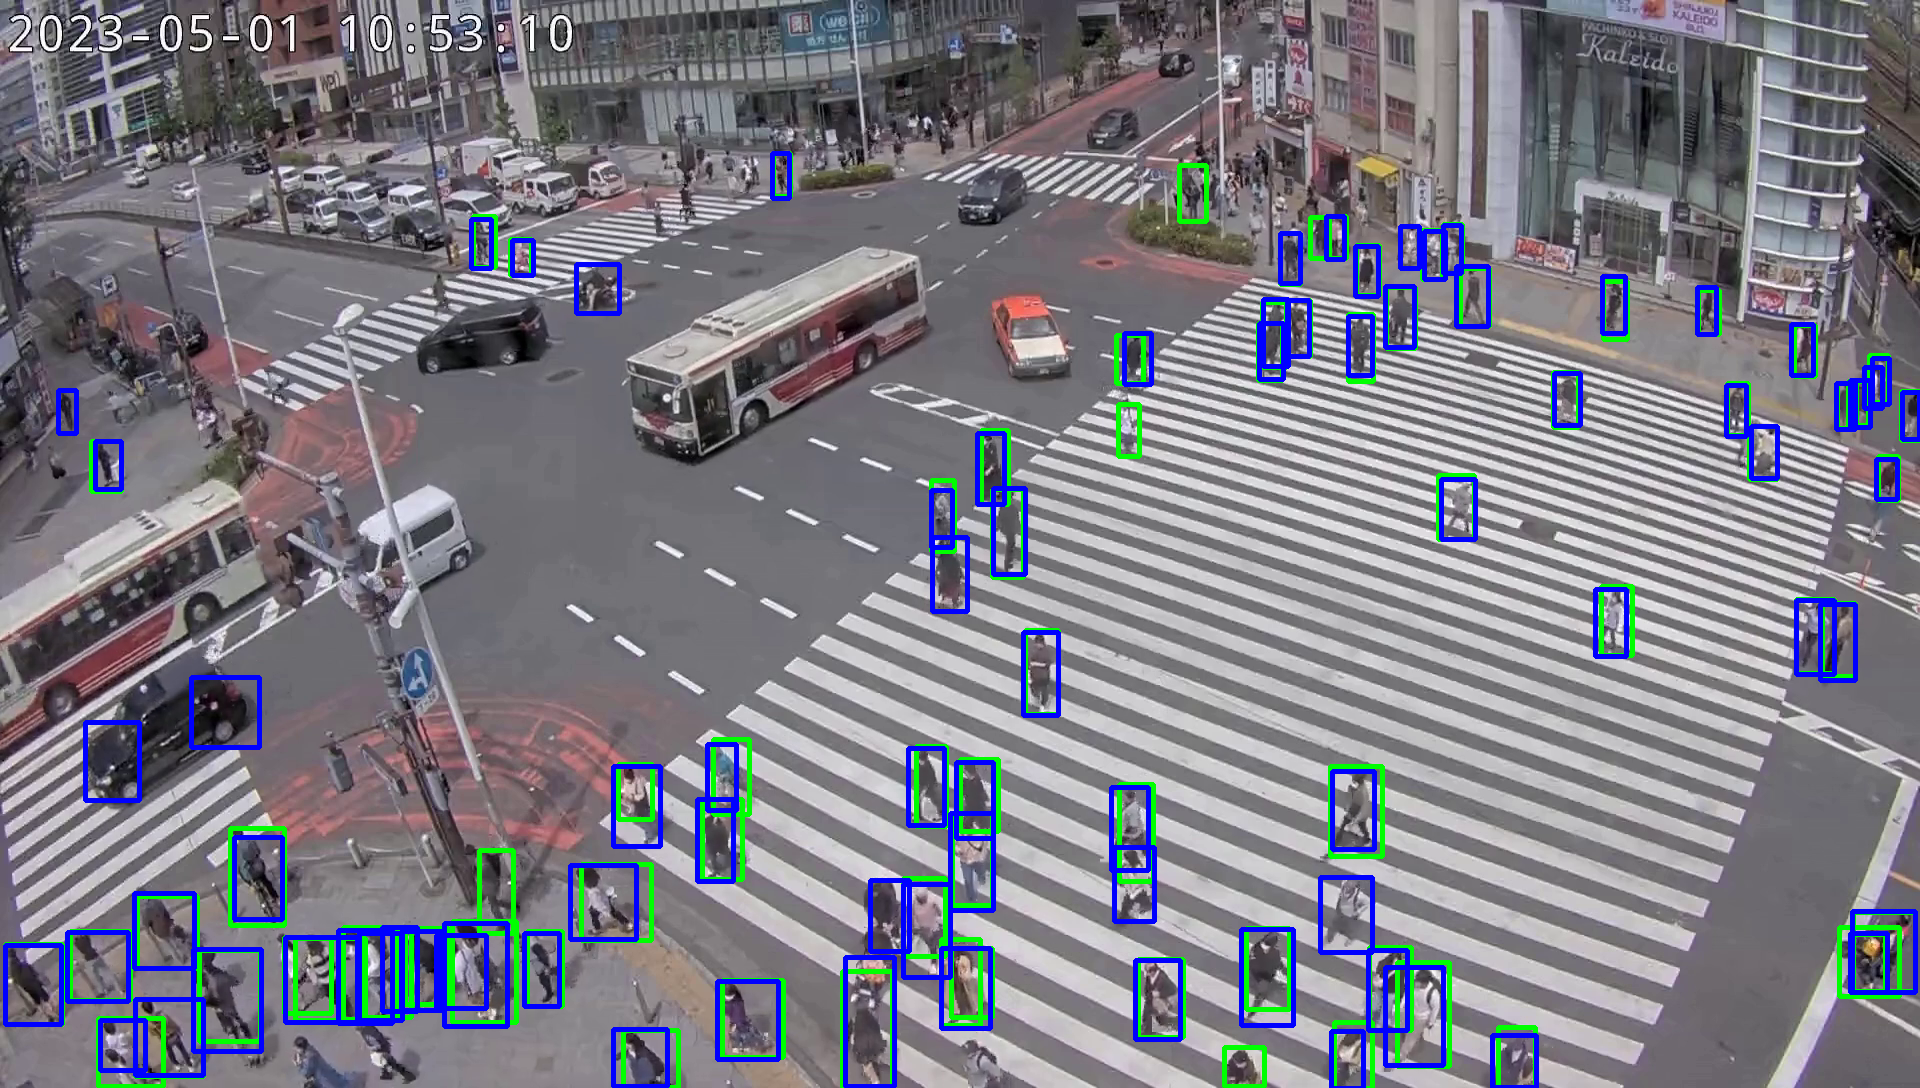

In [ ]:
# Detections img0
track_results0 = inference_detector(model, track_imgs[0], test_pipeline=test_pipeline)
track_detections0 = get_detections_from_result(track_results0)
track_detections0 = filter_detections(track_detections0)

# Detections img1
track_results1 = inference_detector(model, track_imgs[1], test_pipeline=test_pipeline)
track_detections1 = get_detections_from_result(track_results1)
track_detections1 = filter_detections(track_detections1)


tmp = track_imgs[1].copy()
tmp = visualize_boxes(tmp,track_detections0,color=[0,255,0])
tmp = visualize_boxes(tmp,track_detections1,color=[255,0,0])
print("Frame0 Detections in Green. Frame1 Detections in Blue")
cv2_imshow(tmp)

In [ ]:
# Choose a random person from frame0 and calculate IOU for each box in frame1
import random
import numpy as np
def iou(x1_1, y1_1, x2_1, y2_1,
        x1_2, y1_2, x2_2, y2_2):
    intersection_width = max(min(x2_1, x2_2) - max(x1_1, x1_2),0)
    intersection_height = max(min(y2_1, y2_2) - max(y1_1, y1_2),0)
    intersection_area = intersection_width * intersection_height
    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = box1_area + box2_area - intersection_area
    return intersection_area / union_area

my_person = track_detections0[random.randint(0,len(track_detections0)-1)]
ious = [iou(*my_person.box,*det.box) for det in track_detections1]
print("IOUs")
print(ious)

print("")
best_iou_index = np.argmax(np.array(ious))
print(f"Best IOU: {ious[best_iou_index]} at index {best_iou_index}")

my_matched_person = track_detections1[best_iou_index]

IOUs
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.733018, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.33604825, 0.0, 0.0, 0.0]

Best IOU: 0.7330179810523987 at index 37


In [ ]:
# To find another random person, re-run previous cell and this one
tmp = np.zeros_like(track_imgs[1])
tmp = visualize_boxes(tmp,track_detections1,color=[255,0,0])
tmp = visualize_boxes(tmp,[my_person],color=[0,255,0])
tmp = visualize_boxes(tmp,[my_matched_person],color=[0,100,0])
print("All frame1 boxes in blue.\nRandom person from frame0 in light green.\nThe frame1 matched box in dark green")
cv2_imshow(tmp)

In [ ]:
my_tracked_person = None
track_imgs = get_still_images_from_video('small_shinjuku_1.mp4',{0,1})
fig, AX = plt.subplots()
AX.cla()
AX.set_title("Select a person")
tmp=track_imgs[0].copy()
tmp=visualize_boxes(tmp,track_detections0,color=[0,255,0])
tmp = tmp[:,:,::-1]
AX.imshow(tmp)
def find_closest_box(dets,coords):
  closest = 10e4
  closets_index = -1
  ix,iy = coords
  for i,det in enumerate(dets):
    x0,y0,x1,y1 = det.box
    x,y = (x0+x1)/2, (y0+y1)/2
    dist = np.sqrt(((x-ix)**2) + ((y-iy)**2))
    if dist < closest:
      closest = dist
      closest_index = i
  return closest_index

def show_point(coords, label, ax, marker_size=100):
    if label==0:
      color='red'
    else:
      color='green'
    ax.scatter([coords[0]], [coords[1]], color=color, marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
def onclick(event):
    global AX, track_imgs,track_detections0,my_tracked_person
    ix, iy = event.xdata, event.ydata
    if ix and iy:
      coords = [ix,iy]

      i=find_closest_box(track_detections0,coords)
      my_tracked_person = track_detections0[i]
      tmp=track_imgs[0].copy()
      tmp=visualize_boxes(tmp,track_detections0,color=[0,255,0])
      tmp=visualize_boxes(tmp,[my_tracked_person],color=[0,0,255])
      tmp=tmp[:,:,::-1]
      AX.cla()
      AX.set_title("Select a person")
      AX.imshow(tmp)
      show_point(coords,1,AX)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
from IPython.display import HTML
from base64 import b64encode
from copy import deepcopy
def run_video_file(vid_name,tracked_person,max_frames=150,output='tmp'):
    cam = cv2.VideoCapture(vid_name)
    vw = VideoWriter(output)

    frame_num = 0
    while frame_num < max_frames:
      ret,img = cam.read()
      if not ret:
        break
      # Run object detector on image
      result = inference_detector(model, img, test_pipeline=test_pipeline)
      detections = get_detections_from_result(result)
      detections = filter_detections(detections)

      if tracked_person is not None:
        # Calculate IOU for each new detection
        ious = [iou(*tracked_person.box,*det.box) for det in detections]
        best_iou_index = np.argmax(np.array(ious))
        best_iou = ious[best_iou_index]
        # tracked person is updated based on iou
        tracked_person = detections[best_iou_index]

        #If iou is not a positive value, there is no match
        if best_iou <1e-5:
          tracked_person = None

      if tracked_person is not None:
        img = visualize_boxes(img,[tracked_person],[0,0,255])
      vw.write(img)

      frame_num+=1
    vw.release()

FILENAME = 'small_shinjuku_1.mp4'
OUTPUT = 'tmp'
run_video_file(FILENAME,deepcopy(my_tracked_person),output=OUTPUT)

# Show video
mp4 = open(OUTPUT+'.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:


def iou(x1_1, y1_1, x2_1, y2_1,
        x1_2, y1_2, x2_2, y2_2):
    intersection_width = max(min(x2_1, x2_2) - max(x1_1, x1_2),0)
    intersection_height = max(min(y2_1, y2_2) - max(y1_1, y1_2),0)
    intersection_area = intersection_width * intersection_height
    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = box1_area + box2_area - intersection_area
    return intersection_area / union_area
class TrackedObject:
    def __init__(self,idx,box,reset_threshold=60):
        self.idx = idx
        self.box = box
        self.unused_count = 0
        self.start_centroid = [(box[0]+box[2])/2,(box[1]+box[3])/2]#x,y
        self.current_centroid = [(box[0]+box[2])/2,(box[1]+box[3])/2]
        self.has_crossed = False
        self.direction = ''
        self.reset_threshold = reset_threshold
        self.cross_count = 0

    def update(self,box):
        self.box = box
        self.unused_count = 0
        self.current_centroid = [(box[0]+box[2])/2,(box[1]+box[3])/2]#x,y
        if self.has_crossed:
            self.cross_count+=1
            if self.cross_count>=self.reset_threshold:
                self.has_crossed=False
                self.start_centroid = [(box[0]+box[2])/2,(box[1]+box[3])/2]#x,y
    def unused(self):
        self.unused_count+=1
    def get_has_crossed(self):
        return self.has_crossed
    def mark_crossed(self):
        self.has_crossed = True
        self.cross_count = 0
        self.up_or_down()
    def up_or_down(self):
        y0 = self.start_centroid[1]
        y1 = self.current_centroid[1]
        self.direction='up'
        if y1>y0:
            self.direction = 'down'
    def get_unused_count(self):
        return self.unused_count
    def get_direction(self):
        return self.direction
    def get_box(self):
        return self.box
    def get_idx(self):
        return self.idx
    def get_has_crossed(self):
        return self.has_crossed
    def get_start_centroid(self):
        return self.start_centroid
    def get_current_centroid(self):
        return self.current_centroid
    def get_cross_count(self):
        return self.cross_count
class Tracker:
    def __init__(self,unused_threshold=10,printout=False,object_reset_threshold=100):
        self.objects = []
        self.count = 0
        self.unused_threshold = unused_threshold
        self.printout = printout
        self.object_reset_threshold=object_reset_threshold

    def track(self,new_boxes):
        old_boxes = [obj.get_box() for obj in self.objects]
        #old_unmatched = []
        remove_oboxes = [False for _ in old_boxes]
        used_boxes = [False for _ in new_boxes]
        matched = []
        for o,obox in enumerate(old_boxes):
            #greedy
            ious = [self._iou(obox,nbox,ubox) for nbox,ubox in zip(new_boxes,used_boxes)]
            #print(ious)
            idx = self._max_idx(ious)

            if idx is None:
                #old_unmatched.append(self.objects[o])
                self.objects[o].unused()
                #print(ious,idx,self.objects[o].unused_count)
                 # remove lingering boxes
                if self.objects[o].get_unused_count() >= self.unused_threshold:
                    remove_oboxes[o]=True
            else:
                used_boxes[idx]=True
                self.objects[o].update(new_boxes[idx])

        # remove lingering boxes
        self.objects = [obj for obj,rbox in zip(self.objects,remove_oboxes) if not rbox]

        temp = len(self.objects)
        # unmatched new boxes
        for nbox,ubox in zip(new_boxes,used_boxes):
            if not ubox:
                self.objects.append(TrackedObject(self.count,nbox,reset_threshold=self.object_reset_threshold))
                self.count+=1
        if self.printout:

            info = {
                "OldBoxes": len(remove_oboxes),
                "RemovedBoxes": sum(remove_oboxes),
                "Matches": sum(used_boxes),
                "NewBoxes": len(new_boxes),
                "NewBoxesAppended":len(self.objects)-temp,
                "Total": len(self.objects)
            }
            for k,v in info.items():
                print(f"{k}:{v}")
            print('='*40)

    def _iou(self,obox,nbox,ubox):
        if ubox:
            return 0
        return iou(*obox,*nbox)

    def _max_idx(self,my_list):
        # only positive numbers for my_list
        best = 1e-5
        best_idx = None
        for idx,item in enumerate(my_list):
            if item > best:
                best=item
                best_idx = idx
        return best_idx
    def get_objects(self):
        return self.objects


In [ ]:
def run_tracking(vid_name,max_frames=150,output='tmp'):
    cam = cv2.VideoCapture(vid_name)
    vw = VideoWriter(output)

    tracker = Tracker()

    frame_num = 0
    while frame_num < max_frames:
      ret,img = cam.read()
      if not ret:
        break
      # Run object detector on image
      result = inference_detector(model, img, test_pipeline=test_pipeline)
      detections = get_detections_from_result(result)
      detections = filter_detections(detections)

      #Track the object boxes
      tracker.track([det.box for det in detections])
      # visualize tracker
      visualize_tracker(img,tracker)
      vw.write(img)

      frame_num+=1
    vw.release()

FILENAME = 'small_shinjuku_1.mp4'
OUTPUT = 'tmp'
run_tracking(FILENAME,output=OUTPUT)

# Show video
mp4 = open(OUTPUT+'.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Counting

#M

In [ ]:
import matplotlib.pyplot as plt
import cv2



def show_point(coords, label, ax, marker_size=100):
    color = 'green' if label == 1 else 'red'
    ax.scatter([coords[0]], [coords[1]], color=color, marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

CLICKED_POINTS = []
BOUNDARIES = []

first_image = get_still_images_from_video('small_shinjuku_1.mp4',{0})[0]
fig, AX1 = plt.subplots()
AX1.cla()
AX1.set_title("Select 2 points to create boundary")
tmp = first_image.copy()
tmp = tmp[:, :, ::-1]  # Convert BGR to RGB
AX1.imshow(tmp)

def visualize_rectangle(image, points):
    cv2.rectangle(image, tuple(points[0]), tuple(points[1]), (0, 255, 0), 2)

def onclick_boundary(event):
    global AX1, CLICKED_POINTS, first_image, BOUNDARIES
    ix, iy = event.xdata, event.ydata
    if ix is not None and iy is not None:
        coords = [int(ix), int(iy)]
        CLICKED_POINTS.append(coords)

    AX1.cla()
    AX1.set_title("Select 2 points to create boundary")
    tmp = first_image.copy()

    if len(CLICKED_POINTS) == 1:
        show_point(CLICKED_POINTS[0], 1, AX1)

    if len(CLICKED_POINTS) >= 2:
        BOUNDARIES.append(CLICKED_POINTS[:2])
        CLICKED_POINTS = []

    for boundary in BOUNDARIES:
        visualize_rectangle(tmp, boundary)

    tmp = tmp[:, :, ::-1]  # Convert BGR to RGB
    AX1.imshow(tmp)

cid = fig.canvas.mpl_connect('button_press_event', onclick_boundary)

plt.show()


In [ ]:
CLICKED_POINTS = []
BOUNDARIES = []
first_image = get_still_images_from_video('small_shinjuku_1.mp4',{0})[0]
fig, AX1 = plt.subplots()
AX1.cla()
AX1.set_title("Select 2 points to create boundary")
tmp=first_image.copy()
tmp=tmp[:,:,::-1]
AX1.imshow(tmp)

def onclick_boundary(event):
    global AX1, CLICKED_POINTS,first_image,BOUNDARIES
    ix, iy = event.xdata, event.ydata
    AX1.cla()
    AX1.set_title("Select 2 points to create boundary")
    if ix and iy:
      coords = [int(ix),int(iy)]
      CLICKED_POINTS.append(coords)
      if len(CLICKED_POINTS)>=2:
        BOUNDARIES.append(CLICKED_POINTS[:2])
        CLICKED_POINTS = []
      elif len(CLICKED_POINTS)==1:
        show_point(CLICKED_POINTS[0],1,AX1)
    tmp=first_image.copy()
    for tmp_points in BOUNDARIES:
      visualize_line(tmp,tmp_points)
    tmp=tmp[:,:,::-1]
    AX1.imshow(tmp)

cid = fig.canvas.mpl_connect('button_press_event', onclick_boundary)

In [ ]:
print(f"You have {len(BOUNDARIES)} boundary(rectangle) with coordinates below(top_left and bottom_right):\n")
for boundary in BOUNDARIES:
  print(boundary)

You have 1 boundaries with coordinates below:

[[789, 410], [1725, 1052]]


In [ ]:
# @title Main counter class
class Counter:
    def __init__(self, boundary):
        self.boundary = boundary  # (top-left corner, bottom-right corner)
        self.count = 0

    def check_crosses(self, objs):
        for obj in objs:
            if not obj.get_has_crossed() and self.is_inside(obj.get_current_centroid()):
                obj.mark_crossed()
                self.count += 1

    def is_inside(self, centroid):
        x, y = centroid
        (x0, y0), (x1, y1) = self.boundary
        return x0 <= x <= x1 and y0 <= y <= y1

    def reset(self):
        self.count = 0

    def get_results(self):
        return {'count': self.count}

    def get_boundary(self):
        return self.boundary


In [ ]:
# @title test counter class
class Counter:
    def __init__(self,boundary,direction_type='up-down'):
        assert direction_type in {'up-down','left-right'}
        self.direction_type=direction_type
        self.boundary = boundary # point0, point2
        self.reset()
    def check_crosses(self,objs):
        for obj in objs:
            if not obj.get_has_crossed():
                cross_direction = self.check_cross(obj)
                if cross_direction != 'None':
                    obj.mark_crossed()
                    self.totals[cross_direction]+=1
    def reset(self):
        self.totals = {'left':0,'right':0}
        if self.direction_type=='up-down':
          self.totals = {'up':0,'down':0}

    def check_cross(self,obj):
        x0_0, y0_0 = self.boundary[0]
        x1_0, y1_0 = self.boundary[1]
        x0_1, y0_1 = obj.get_start_centroid()
        x1_1, y1_1 = obj.get_current_centroid()
        dx0 = x1_0 - x0_0
        dy0 = y1_0 - y0_0
        dx1 = x1_1 - x0_1
        dy1 = y1_1 - y0_1
        denominator = dx1 * dy0 - dy1 * dx0
        if denominator == 0:
            return 'None'  # lines are parallel
        t = ((x0_0 - x0_1) * dy1 - (y0_0 - y0_1) * dx1) / denominator
        u = ((x0_0 - x0_1) * dy0 - (y0_0 - y0_1) * dx0) / denominator
        if 0 <= t <= 1 and 0 <= u <= 1:
            # UP DOWN
            if self.direction_type=='up-down':
                if y1_1 > y0_1:
                    return 'down'
                return 'up'
            # LEFT RIGHT
            if x1_1 > x0_1:
                return 'right'
            return 'left'
        return 'None'  # segments do not intersect
    def get_results(self):
        return self.totals
    def get_boundary(self):
        return self.boundary


counting people in the fixed box with accumulating on every frame

In [ ]:
import cv2
from base64 import b64encode
from IPython.display import HTML

def run_counting(vid_name, boundaries, max_frames=300, output='tmp'):
    cam = cv2.VideoCapture(vid_name)
    vw = VideoWriter(output)

    tracker = Tracker()
    counters = [Counter(boundary) for boundary in boundaries]

    frame_num = 0
    while frame_num < max_frames:
        ret, img = cam.read()
        if not ret:
            break

        # Run object detector on image
        result = inference_detector(model, img, test_pipeline=test_pipeline)
        detections = get_detections_from_result(result)
        detections = filter_detections(detections)

        # Track the object boxes
        tracker.track([det.box for det in detections])
        visualize_tracker(img, tracker)

        # Count
        for counter in counters:
            visualize_rectangle(img, counter.get_boundary())
            counter.check_crosses(tracker.get_objects())
        counts = [counter.get_results() for counter in counters]

        # Get counts and display that on image
        text = ' | '.join([f"Count: {count['count']}" for count in counts])
        display_text_box(img, text)

        vw.write(img)
        frame_num += 1

    vw.release()



FILENAME = 'small_shinjuku_1.mp4'
OUTPUT = 'tmp'
run_counting(FILENAME, BOUNDARIES, output=OUTPUT)

# Show video
mp4 = open(OUTPUT + '.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


counting people in the fixed box with reseting for every frame(what you want)

In [ ]:
import cv2
from base64 import b64encode
from IPython.display import HTML

class Counter:
    def __init__(self, boundary):
        self.boundary = boundary  # (top-left corner, bottom-right corner)

    def is_inside(self, centroid):
        x, y = centroid
        (x0, y0), (x1, y1) = self.boundary
        return x0 <= x <= x1 and y0 <= y <= y1

    def get_boundary(self):
        return self.boundary

def run_counting(vid_name, boundaries, max_frames=300, output='tmp'):
    cam = cv2.VideoCapture(vid_name)
    vw = VideoWriter(output)

    tracker = Tracker()
    counters = [Counter(boundary) for boundary in boundaries]

    frame_num = 0
    while frame_num < max_frames:
        ret, img = cam.read()
        if not ret:
            break

        # Run object detector on image
        result = inference_detector(model, img, test_pipeline=test_pipeline)
        detections = get_detections_from_result(result)
        detections = filter_detections(detections)

        # Track the object boxes
        tracker.track([det.box for det in detections])
        visualize_tracker(img, tracker)

        # Reset and Count within rectangles
        current_counts = {counter: 0 for counter in counters}
        for obj in tracker.get_objects():
            for counter in counters:
                if counter.is_inside(obj.get_current_centroid()):
                    # Draw black box for objects inside the rectangle
                    box = obj.get_box()
                    cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 0), 2)
                    current_counts[counter] += 1

        # Visualize rectangles and display counts
        for counter in counters:
            visualize_rectangle(img, counter.get_boundary())
            text = f"Count: {current_counts[counter]}"
            display_text_box(img, text, counter.get_boundary())

        vw.write(img)
        frame_num += 1

    vw.release()
    cam.release()

def visualize_rectangle(img, boundary):
    """Draws a rectangle on the image based on the boundary"""
    cv2.rectangle(img, (boundary[0][0], boundary[0][1]), (boundary[1][0], boundary[1][1]), (255, 0, 0), 2)

def display_text_box(img, text, boundary):
    """Display the count text near the top-left corner of the rectangle"""
    font = cv2.FONT_HERSHEY_SIMPLEX
    position = (boundary[0][0] + 10, boundary[0][1] - 10)
    cv2.putText(img, text, position, font, 0.8, (255, 255, 255), 2, cv2.LINE_AA)


FILENAME = 'small_shinjuku_1.mp4'
OUTPUT = 'tmp'
run_counting(FILENAME, BOUNDARIES, output=OUTPUT)

# Show video
mp4 = open(OUTPUT + '.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


Wrote to tmp.mp4
